# RNN - GRU : 5 epochs and 0.5 of dataset

In [1]:
from common.text_classification_utils import *

dataset = load_dataset()

dataset

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nathp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,CORRECT,NOT_FRENCH,NOT_TRIP,UNKNOWN
0,zrkrwmgseetfegaozv kovx vh,0,0,0,1
1,Comment puis-je me rendre de l'aéroport de CHA...,1,0,0,0
2,4f3;S0`HsL# hL8ydlwlM2cK7=,0,0,0,1
3,"u*]P\UsbAr,CoDnDdr*-GKN(0O",0,0,0,1
4,J'aimerais connaître le chemin pour aller de S...,1,0,0,0
...,...,...,...,...,...
1302960,Il a prétendu être mon ami.,0,0,1,0
1302961,I am planning a trip from saint paul les dax t...,0,1,0,0
1302962,Go from the train station of Loches to Venarey...,0,1,0,0
1302963,Je souhaiterais aller à verneuil sur serre dep...,1,0,0,0


In [2]:
labels, id2label, label2id = prepare_labels(dataset)

['CORRECT', 'NOT_FRENCH', 'NOT_TRIP', 'UNKNOWN']


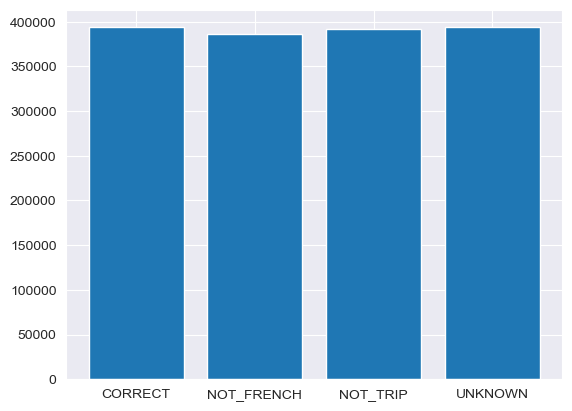

In [3]:
show_labels_distribution(dataset, labels)

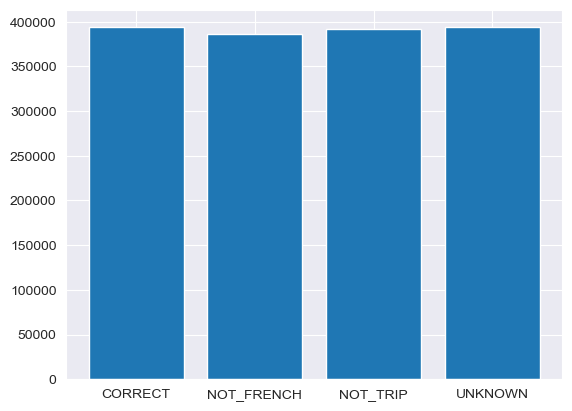

In [4]:
dataset = flatten_trips_labels(dataset)

show_labels_distribution(dataset, labels)

In [5]:
from sklearn.model_selection import train_test_split
# Shuffle train dataset, and pick 20% of it
dataset = dataset.sample(frac=0.2, random_state=0)
X_train = dataset['text']
y_train = dataset[labels]

# To check how vectorizer works without UNKNOWN words being isolated
X_train_without_unknown = dataset[dataset['UNKNOWN'] == 0]['text']
y_train_without_unknown = dataset[dataset['UNKNOWN'] == 0][labels]

# Split test dataset into 10% validation and 10% test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(208474,) (26059,) (26060,)
(208474, 4) (26059, 4) (26060, 4)


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paramètres de tokenisation
vocab_size = 20000  # Choisissez une taille adaptée à votre vocabulaire
max_length = 100    # Longueur maximale des séquences

# Initialisation du tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Conversion des textes en séquences de tokens
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# Padding des séquences pour qu'elles aient la même longueur
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

embedding_dim = 128
gru_units = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(GRU(gru_units))
model.add(Dense(4, activation='sigmoid'))  # Ajustez à 4 pour quatre labels

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 2,597,508
Trainable params: 2,597,508
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 5
model.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_val_padded, y_val))


Epoch 1/5
6515/6515 [==============================] - 140s 21ms/step - loss: 0.0177 - accuracy: 0.8609 - val_loss: 0.0048 - val_accuracy: 0.8509
Epoch 2/5
6515/6515 [==============================] - 132s 20ms/step - loss: 0.0035 - accuracy: 0.8532 - val_loss: 0.0049 - val_accuracy: 0.8502
Epoch 3/5
6515/6515 [==============================] - 131s 20ms/step - loss: 0.0027 - accuracy: 0.8422 - val_loss: 0.0054 - val_accuracy: 0.8391
Epoch 4/5
6515/6515 [==============================] - 131s 20ms/step - loss: 0.0024 - accuracy: 0.8524 - val_loss: 0.0051 - val_accuracy: 0.8552
Epoch 5/5
6515/6515 [==============================] - 133s 20ms/step - loss: 0.0022 - accuracy: 0.8446 - val_loss: 0.0050 - val_accuracy: 0.8409


In [9]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_padded)
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

print(classification_report(y_test, y_pred_binary, target_names=labels))

815/815 [==============================] - 7s 8ms/step
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      7764
  NOT_FRENCH       1.00      1.00      1.00      7749
    NOT_TRIP       1.00      1.00      1.00      7868
     UNKNOWN       1.00      1.00      1.00      7948

   micro avg       1.00      1.00      1.00     31329
   macro avg       1.00      1.00      1.00     31329
weighted avg       1.00      1.00      1.00     31329
 samples avg       1.00      1.00      1.00     31329



C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
print("Distribution des labels dans l'ensemble d'entraînement :")
print(y_train.sum(axis=0))  # Somme pour chaque label dans y_train

print("\nDistribution des labels dans l'ensemble de test :")
print(y_test.sum(axis=0))   # Somme pour chaque label dans y_test


Distribution des labels dans l'ensemble d'entraînement :
CORRECT       62964
NOT_FRENCH    61733
NOT_TRIP      62654
UNKNOWN       62922
dtype: int64

Distribution des labels dans l'ensemble de test :
CORRECT       7764
NOT_FRENCH    7749
NOT_TRIP      7868
UNKNOWN       7948
dtype: int64


In [11]:
from sklearn.metrics import classification_report
import numpy as np

for threshold in np.arange(0.1, 0.9, 0.1):
    y_pred_binary = (y_pred > threshold).astype(int)
    print(f"Seuil: {threshold}")
    print(classification_report(y_test, y_pred_binary, target_names=labels))


C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Seuil: 0.1
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      7764
  NOT_FRENCH       0.99      1.00      0.99      7749
    NOT_TRIP       0.99      1.00      1.00      7868
     UNKNOWN       0.99      1.00      1.00      7948

   micro avg       0.99      1.00      1.00     31329
   macro avg       0.99      1.00      1.00     31329
weighted avg       0.99      1.00      1.00     31329
 samples avg       1.00      1.00      1.00     31329

Seuil: 0.2
              precision    recall  f1-score   support

     CORRECT       1.00      1.00      1.00      7764
  NOT_FRENCH       1.00      1.00      1.00      7749
    NOT_TRIP       1.00      1.00      1.00      7868
     UNKNOWN       0.99      1.00      1.00      7948

   micro avg       1.00      1.00      1.00     31329
   macro avg       1.00      1.00      1.00     31329
weighted avg       1.00      1.00      1.00     31329
 samples avg       1.00      1.00      1.00     31329



C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nathp\anaconda3\lib\site-packages\sklearn\metr

In [12]:
indices = np.random.choice(range(len(y_test)), 10, replace=False)  # Choisir 10 échantillons au hasard
for i in indices:
    print("Vrai label:", y_test.iloc[i].to_list())
    print("Prédiction:", y_pred_binary[i])
    print()


Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 0, 0]
Prédiction: [0 1 0 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 1, 0, 0]
Prédiction: [0 1 0 0]

Vrai label: [1, 0, 0, 0]
Prédiction: [1 0 0 0]

Vrai label: [0, 1, 1, 0]
Prédiction: [0 1 1 0]

Vrai label: [1, 0, 0, 0]
Prédiction: [1 0 0 0]

Vrai label: [1, 0, 0, 0]
Prédiction: [1 0 0 0]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]

Vrai label: [0, 0, 0, 1]
Prédiction: [0 0 0 1]



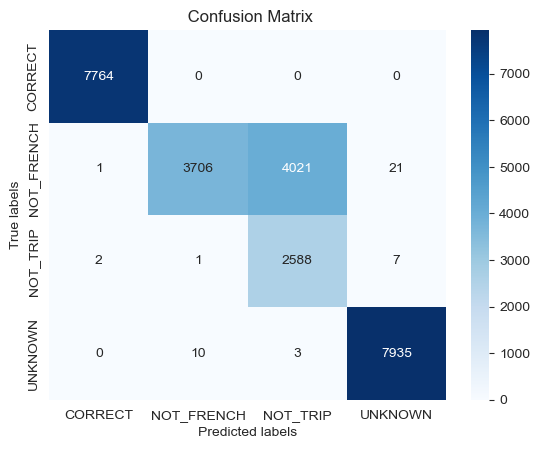

In [13]:
show_confusion_matrix(y_pred, y_test, labels)

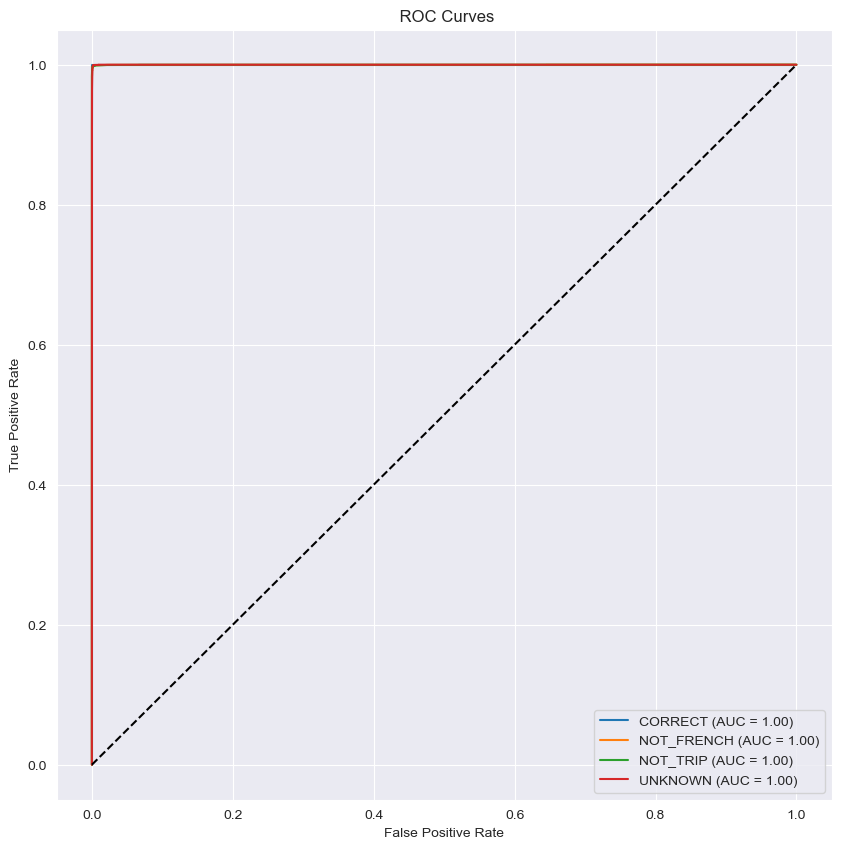

In [14]:
show_roc_curves(labels, y_pred, y_test)

In [15]:
new_texts = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je veux aller de Port-Boulet au Havre.",
    "Je vais de Nantes à Paris.",
    "Je vais de Nantes à Nantes.",
    "Je veux aller de Nantes à Nantes.",
    "Je vais à Port-Boulet en partant de Le Havre",
    "Je vais à Port-Boulet en partant du Havre",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "Recherche le chemin le plus court entre la ville de Lorient et Paris",
    "Trouve-moi un itinéraire pour aller à Besançon depuis la ville d'Oyonnax.",
    "Ca met combien de temps un Toulouse Paris ?",
    "C'est quoi le trajet de Troyes à Niort ?",
    "Comment aller à Niort depuis Troyes ?",
    "Comment aller à Niort depuis Troyes",
    "Recherche un itinéraire de Nantes à Paris où habite Théo",
    "Trouve-moi le chemin le plus rapide vers Paris depuis Nantes pour arriver chez Michel.",
    "Il y a-t-il des trains de Nantes à Montaigu"
]
new_texts_sequences = tokenizer.texts_to_sequences(new_texts)
new_texts_padded = pad_sequences(new_texts_sequences, maxlen=max_length)

predicted_labels = model.predict(new_texts_padded)

# Affichage des labels prédits
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    print("Predicted labels:")
    for j, label in enumerate(labels):
        print(f" - {label}: {round(predicted_labels[i][j] * 100, 2)}%")

1/1 [==============================] - 0s 32ms/step
Text: Je veux aller de Port-Boulet à Le Havre.
Predicted labels:
 - CORRECT: 100.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 0.02%
 - UNKNOWN: 0.03%
Text: Je veux aller de Port-Boulet au Havre.
Predicted labels:
 - CORRECT: 0.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 99.96%
 - UNKNOWN: 0.03%
Text: Je vais de Nantes à Paris.
Predicted labels:
 - CORRECT: 100.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 0.01%
 - UNKNOWN: 0.0%
Text: Je vais de Nantes à Nantes.
Predicted labels:
 - CORRECT: 100.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 0.0%
 - UNKNOWN: 0.01%
Text: Je veux aller de Nantes à Nantes.
Predicted labels:
 - CORRECT: 100.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 0.0%
 - UNKNOWN: 0.02%
Text: Je vais à Port-Boulet en partant de Le Havre
Predicted labels:
 - CORRECT: 100.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 0.0%
 - UNKNOWN: 0.01%
Text: Je vais à Port-Boulet en partant du Havre
Predicted labels:
 - CORRECT: 100.0%
 - NOT_FRENCH: 0.0%
 - NOT_TRIP: 0.0%
 - UNKNOWN: 0.0%